---
# Clustering and Classification using Knowledge Graph Embeddings
---

In this tutorial we will explore how to use the knowledge embeddings generated by a graph of international football matches (since the 19th century) in clustering and classification tasks. Knowledge graph embeddings are typically used for missing link prediction and knowledge discovery, but they can also be used for entity clustering, entity disambiguation, and other downstream tasks. The embeddings are a form of representation learning that allow linear algebra and machine learning to be applied to knowledge graphs, which otherwise would be difficult to do.


We will cover in this tutorial:

1. Creating the knowledge graph (i.e. triples) from a tabular dataset of football matches
2. Training the ComplEx embedding model on those triples
3. Evaluating the quality of the embeddings on a validation set
4. Clustering the embeddings, comparing to the natural clusters formed by the geographical continents
5. Applying the embeddings as features in classification task, to predict match results
6. Evaluating the predictive model on a out-of-time test set, comparing to a simple baseline

We will show that knowledge embedding clusters manage to capture implicit geographical information from the graph and that they can be a useful feature source for a downstream machine learning classification task, significantly increasing accuracy from the baseline.

---

## Requirements

A Python environment with the AmpliGraph library installed. Please follow the [install guide](http://docs.ampligraph.org/en/latest/install.html).

Some sanity check:

In [ ]:
!pip install tensorflow==2.9.0
!pip install ampligraph

ERROR: Could not find a version that satisfies the requirement tensorflow==2.9.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.9.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.

In [ ]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

## Dataset

We will use the [International football results from 1872 to 2019](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017) available on Kaggle (public domain). It contains over 40 thousand international football matches. Each row contains the following information:
1. Match date
2. Home team name
3. Away team name
4. Home score (goals including extra time)
5. Away score (goals including extra time)
6. Tournament (whether it was a friendly match or part of a tournament)
7. City where match took place
8. Country where match took place
9. Whether match was on neutral grounds

This dataset comes in a tabular format, therefore we will need to construct the knowledge graph ourselves.

In [ ]:
import requests

url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/football_graph.csv'
open('football_results.csv', 'wb').write(requests.get(url).content)

3033782

In [ ]:
df = pd.read_csv("football_results.csv").sort_values("date")

In [ ]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    2
away_score    2
tournament    0
city          0
country       0
neutral       0
dtype: int64

Dropping matches with unknown score:

In [ ]:
df = df.dropna()

The training set will be from 1872 to 2014, while the test set will be from 2014 to present date. Note that a temporal test set makes any machine learning task harder compared to a random shuffle.

In [ ]:
df["train"] = df.date < "2014-01-01"

In [ ]:
df.train.value_counts()

train
True     35714
False     5057
Name: count, dtype: int64

## Knowledge graph creation
We are going to create a knowledge graph from scratch based on the match information. The idea is that each match is an entity that will be connected to its participating teams, geography, characteristics, and results.

The objective is to generate a new representation of the dataset where each data point is an triple in the form:

    <subject, predicate, object>
    
First we need to create the entities (subjects and objects) that will form the graph. We make sure teams and geographical information result in different entities (e.g. the Brazilian team and the corresponding country will be different).

In [ ]:
# Entities naming
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["city_id"] = "City" + df.city.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["tournament_id"] = "Tournament" + df.tournament.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

Then, we create the actual triples based on the relationship between the entities. We do it only for the triples in the training set (before 2014).

In [ ]:
triples = []
for _, row in df[df["train"]].iterrows():
    # Home and away information
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])

    # Match results
    if row["home_score"] > row["away_score"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    elif row["home_score"] < row["away_score"]:
        score_away = (row["away_team_id"], "winnerOf", row["match_id"])
        score_home = (row["home_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["home_team_id"], "draws", row["match_id"])
        score_away = (row["away_team_id"], "draws", row["match_id"])
    home_score = (row["match_id"], "homeScores", np.clip(int(row["home_score"]), 0, 5))
    away_score = (row["match_id"], "awayScores", np.clip(int(row["away_score"]), 0, 5))

    # Match characteristics
    tournament = (row["match_id"], "inTournament", row["tournament_id"])
    city = (row["match_id"], "inCity", row["city_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][:4])

    triples.extend((home_team, away_team, score_home, score_away,
                    tournament, city, country, neutral, year, home_score, away_score))

Note that we treat some literals (year, neutral match, home score, away score) as discrete entities and they will be part of the final knowledge graph used to generate the embeddings. We limit the number of score entities by clipping the score to be at most 5.

Below we can see visualise a subset of the graph related to the infamous [Maracanazo](https://en.wikipedia.org/wiki/Uruguay_v_Brazil_(1950_FIFA_World_Cup)):

![Football graph](https://github.com/Accenture/AmpliGraph/blob/main/docs/tutorials/img/FootballGraph.png?raw=1)

The whole graph related to this match can be summarised by the triples below:

In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Match3129") | (triples_df.object=="Match3129")]

,subject,predicate,object
34419,TeamBrazil,isHomeTeamIn,Match3129
34420,TeamUruguay,isAwayTeamIn,Match3129
34421,TeamBrazil,loserOf,Match3129
34422,TeamUruguay,winnerOf,Match3129
34423,Match3129,inTournament,TournamentFifaWorldCup
34424,Match3129,inCity,CityRioDeJaneiro
34425,Match3129,inCountry,CountryBrazil
34426,Match3129,isNeutral,False
34427,Match3129,atYear,1950
34428,Match3129,homeScores,1


#### Example [RML](https://rml.io/) mapping

In [ ]:
# @prefix rr: <http://www.w3.org/ns/r2rml#>.
# @prefix rml: <http://semweb.mmlab.be/ns/rml#>.
# @prefix ql: <http://semweb.mmlab.be/ns/ql#>.
# @prefix xsd: <http://www.w3.org/2001/XMLSchema#>.
# @prefix ex: <http://example.com/ns#>.
# @prefix dbo: <http://dbpedia.org/ontology#/>.
# @prefix fno: <http://w3id.org/function/ontology#>.
# @prefix grel: <http://users.ugent.be/~bjdmeest/function/grel.ttl#>.

# <#Football_match>

#   rml:logicalSource [
#     rml:source "football_results.csv";
#     rml:referenceFormulation ql:CSV
#   ];


#   rr:subjectMap [
#     rr:template "http://ex.com/Team/Team{home_team}";
#     rr:class dbo:FootballTeam
#   ];

#   rr:subjectMap [
#     rr:template "http://ex.com/Team/Team{away_team}";
#     rr:class dbo:FootballTeam
#   ];

#   rr:subjectMap [
#     rr:template "http://ex.com/Match/{match_id}";
#     rr:class dbo:SportsEvent
#   ];


#   rr:predicateObjectMap [
#     rr:predicate ex:isHomeTeamIn;
#     rr:objectMap [
#       rml:reference "match_id"
#     ]
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:isAwayTeamIn;
#     rr:objectMap [
#       rml:reference "match_id"
#     ]
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:inTournament;
#     rr:objectMap [
#       rml:reference "tournament_id"
#     ]
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:inCity;
#     rr:objectMap [
#       rml:reference "city_id"
#     ]
#   ].

#### Example output data

<http://ex.com/Team/TeamScotland> ex:isHomeTeamIn Match0.

<http://ex.com/Team/TeamEngland> ex:isAwayTeamIn Match0.
        
<http://ex.com/Match/Match0> ex:inTournament TournamentFriendly.
        
<http://ex.com/Match/Match0> ex:inCity CityGlasgow.

## Training knowledge graph embeddings

We split our training dataset further into training and validation, where the new training set will be used to the knowledge embedding training and the validation set will be used in its evaluation. The test set will be used to evaluate the performance of the classification algorithm built on top of the embeddings.

What differs from the standard method of randomly sampling N points to make up our validation set is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and validation sets by at least one triple.

To accomplish this, AmpliGraph provides the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.train_test_split_no_unseen.html#train-test-split-no-unseen) function.

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [ ]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (382854, 3)
Test set size:  (10000, 3)


In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

AmpliGraph has implemented [several Knowledge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model, which is known to bring state-of-the-art predictive power.

The hyper-parameter choice was based on the [best results](https://docs.ampligraph.org/en/latest/experiments.html) we have found so far for the ComplEx model applied to some benchmark datasets used in the knowledge graph embeddings community. This tutorial does not cover [hyper-parameter tuning](https://docs.ampligraph.org/en/latest/examples.html#model-selection).

Lets go through the parameters to understand what's going on:

- **`k`**: the dimensionality of the embedding space.
- **`eta`** ($\\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple.
- **`scoring_type`**: type of model defined by spicific scoring function.
- **`seed`** : random seed, used for reproducibility.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-4 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=3$, i.e. l3 regularization. $\\lambda$ = 1e-5, set via the *regularizer_params* kwarg.

Training should take around 10 minutes on a modern GPU:

In [ ]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=300, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/300
52/52 [==============================] - 72s 1s/step - loss: 22855.0566
Epoch 2/300
52/52 [==============================] - 64s 1s/step - loss: 22854.8477
Epoch 3/300
52/52 [==============================] - 63s 1s/step - loss: 22854.5762
Epoch 4/300
52/52 [==============================] - 63s 1s/step - loss: 22854.0996
Epoch 5/300
52/52 [==============================] - 63s 1s/step - loss: 22853.2461
Epoch 6/300
52/52 [==============================] - 63s 1s/step - loss: 22851.8145
Epoch 7/300
52/52 [==============================] - 64s 1s/step - loss: 22849.5273
Epoch 8/300
52/52 [==============================] - 63s 1s/step - loss: 22846.0977
Epoch 9/300
52/52 [==============================] - 64s 1s/step - loss: 22841.2402
Epoch 10/300
52/52 [==============================] - 102s 2s/step - loss: 22834.6426
Epoch 11/300
52/52 [==============================] - 64s 1s/step - loss: 22826.0371
Epoch 12/300
52/52 [==============================] - 64s 1s/step - loss:

## Evaluating knowledge embeddings

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions.

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply can be done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

For this we'll use method `evaluate` of model object:

- **`X_valid`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`use_filter`** - will filter out the false negatives generated by the corruption strategy.
- **`corrupt_side`** - specifies approach for triple corruption. 's,o' option means t True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - displays a progress bar.

In [ ]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

1001/1001 [==============================] - 507s 507ms/step


We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions.

- **mrr_score**: The function computes the mean of the reciprocal of elements of a vector of rankings ranks.
- **hits_at_n_score**: The function computes how many elements of a vector of rankings ranks make it to the top n positions.

In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.30
MR: 2996.97
Hits@10: 0.41
Hits@3: 0.34
Hits@1: 0.22


We can interpret these results by stating that the model will rank the correct entity within the top-3 possibilities 34% of the time.

By themselves, these metrics are not enough to conclude the usefulness of the embeddings in a downstream task, but they suggest that the embeddings have learned a reasonable representation enough to consider using them in more tasks.

## Clustering and embedding visualization

To evaluate the subjective quality of the embeddings, we can visualise the embeddings on 2D space and also cluster them on the original space. We can compare the clustered embeddings with natural clusters, in this case the continent where the team is from, so that we have a ground truth to evaluate the clustering quality both qualitatively and quantitatively.

Requirements:

* seaborn
* adjustText
* incf.countryutils

For seaborn and adjustText, simply install them with `pip install seaborn adjustText`.

For incf.countryutils, do the following steps:
```bash
git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
cd incf.countryutils
pip install .```

In [ ]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

Cloning into 'incf.countryutils'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 132 (delta 20), reused 39 (delta 16), pack-reused 87 (from 1)
Receiving objects: 100% (132/132), 66.24 KiB | 11.04 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Processing /kaggle/working/incf.countryutils
  Preparing metadata (setup.py) ... - done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=25701 sha256=b954eede029d75c27d2043e483a748f45ebc4e999559ee6f886236a6033d83bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0cvm19e/wheels/85/d8/f8/1c1edf5312ef76d4a9163230beb3fbcde6825c623243fa4087
Successfully built incf.countryutils


In [ ]:
!pip install adjustText

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

We create a map from the team ID (e.g. "TeamBrazil") to the team name (e.g. "Brazil") for visualization purposes.

In [ ]:
id_to_name_map = {**dict(zip(df.home_team_id, df.home_team)), **dict(zip(df.away_team_id, df.away_team))}

We now create a dictionary with the embeddings of all teams:

In [ ]:
teams = pd.concat((df.home_team_id[df["train"]], df.away_team_id[df["train"]])).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

We use PCA to project the embeddings from the 200 space into 2D space:

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

We will cluster the teams embeddings on its original 200-dimensional space using the `find_clusters` in our discovery API:

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(teams, model, clustering_algorithm, mode='e')

This helper function uses the `incf.countryutils` library to translate country names to their corresponding continents.

In [ ]:
def cn_to_ctn(country):
    try:
        return transformations.cn_to_ctn(id_to_name_map[country])
    except KeyError:
        return "unk"

This dataframe contains for each team their projected embeddings to 2D space via PCA, their continent and the KMeans cluster. This will be used alongisde Seaborn to make the visualizations.

In [ ]:
plot_df = pd.DataFrame({"teams": teams,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "continent": pd.Series(teams).apply(cn_to_ctn),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

We plot the results on a 2D scatter plot, coloring the teams by the continent or cluster and also displaying some individual team names.

We always display the names of the top 20 teams (according to [FIFA rankings](https://en.wikipedia.org/wiki/FIFA_World_Rankings)) and a random subset of the rest.

In [ ]:
top20teams = ["TeamBelgium", "TeamFrance", "TeamBrazil", "TeamEngland", "TeamPortugal", "TeamCroatia", "TeamSpain",
              "TeamUruguay", "TeamSwitzerland", "TeamDenmark", "TeamArgentina", "TeamGermany", "TeamColombia",
              "TeamItaly", "TeamNetherlands", "TeamChile", "TeamSweden", "TeamMexico", "TeamPoland", "TeamIran"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.continent!="unk"], x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["teams"] in top20teams or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["teams"])))
    adjust_text(texts)

The first visualisation of the 2D embeddings shows the natural geographical clusters (continents), which can be seen as a form of the ground truth:

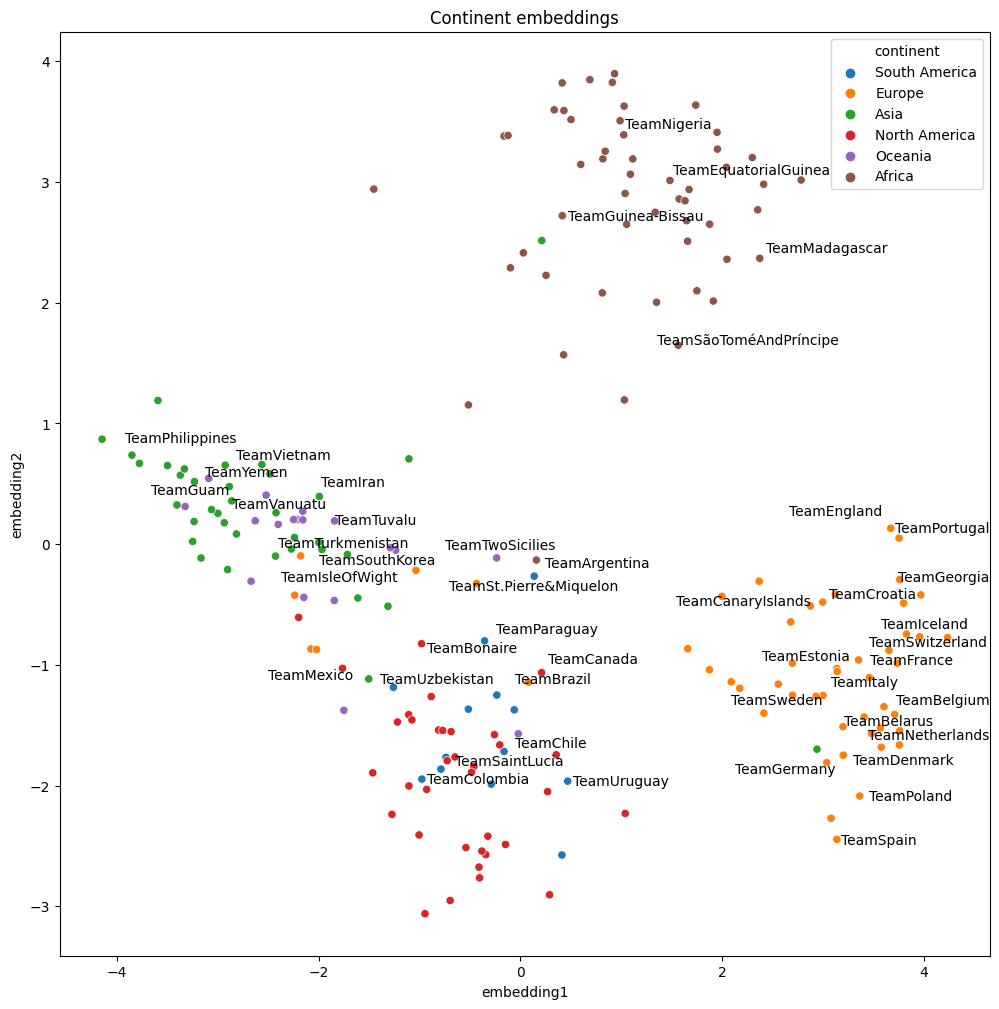

In [ ]:
plot_clusters("continent")

We can see above that the embeddings learned geographical similarities even though this information was not explicit on the original dataset.

Now we plot the same 2D embeddings but with the clusters found by K-Means:

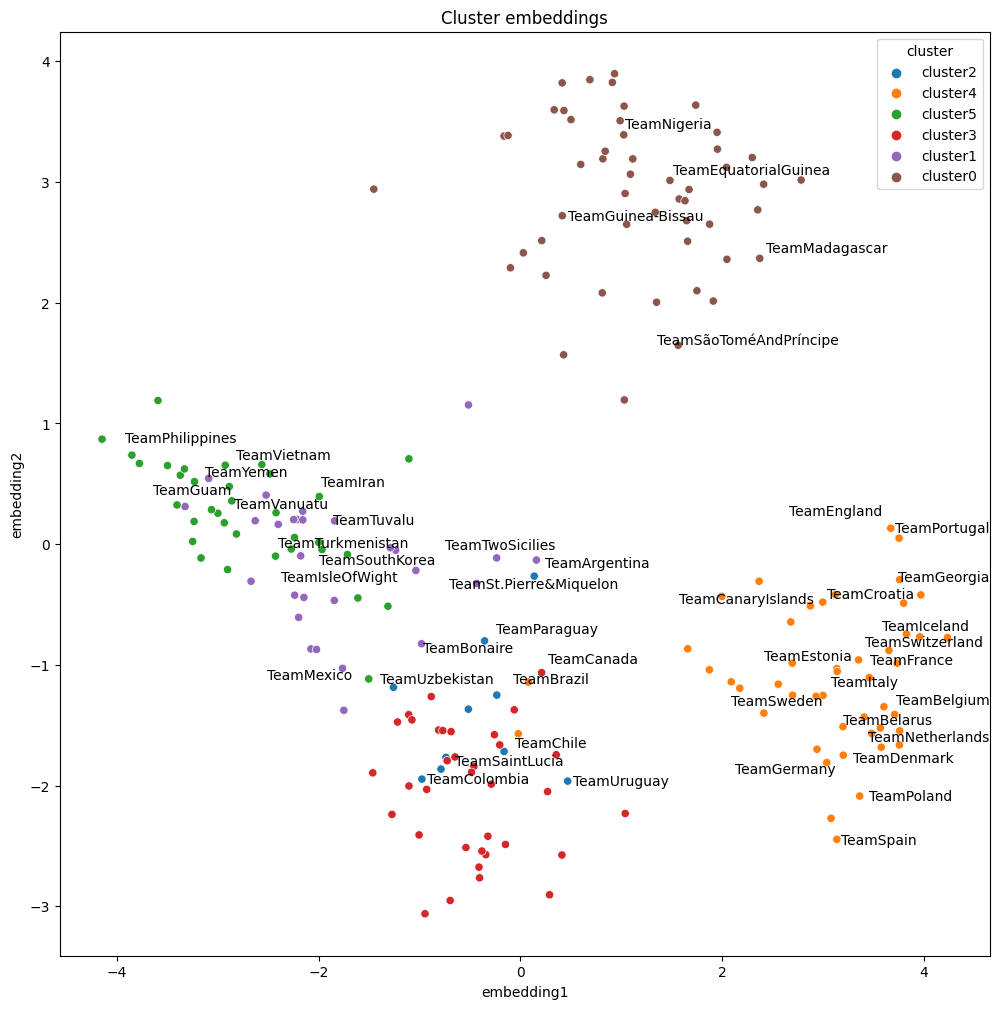

In [ ]:
plot_clusters("cluster")

We can see that K-Means found very similar cluster to the natural geographical clusters by the continents. This shows that on the 200-dimensional embedding space, similar teams appear close together, which can be captured by a clustering algorithm.

Our evaluation of the clusters can be more objective by using a metric such as the [adjusted Rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html), which varies from -1 to 1, where 0 is random labelling and 1 is a perfect match:

In [ ]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.continent, plot_df.cluster)

0.4960460985737154

## Classification

We will use the knowledge embeddings to predict future matches as a classification problem.

We can model it as a multiclass problem with three classes: home team wins, home team loses, draw.

The embeddings are used directly as features to a XGBoost classifier.

First we need to determine the target:

In [ ]:
df["results"] = (df.home_score > df.away_score).astype(int) + \
                (df.home_score == df.away_score).astype(int)*2 + \
                (df.home_score < df.away_score).astype(int)*3 - 1

In [ ]:
df.results.value_counts(normalize=True)

results
0    0.486473
2    0.282456
1    0.231071
Name: proportion, dtype: float64

### Original dataset

First install xgboost with `pip install xgboost`.

In [ ]:
!pip install xgboost

In [ ]:
new_df = df[["results", "neutral", "train"]].copy()
new_df

,results,neutral,train
0,1,False,True
1,0,False,True
2,0,False,True
3,1,False,True
4,0,False,True
...,...,...,...
40766,0,True,False
40767,1,True,False
40768,2,True,False
40769,0,True,False


In [ ]:
new_df.neutral = new_df.neutral.astype(bool)

Split date:

In [ ]:
new_df["year"] = df["date"].apply(lambda x: int(x[:4]))
new_df["month"] = df["date"].apply(lambda x: int(x[5:7]))
new_df["day"] = df["date"].apply(lambda x: int(x[8:]))

Apply one hot encoding:

In [ ]:
encoded_cols = pd.get_dummies(df[["home_team", "away_team", "tournament", "city", "country"]])
encoded_cols

,home_team_Abkhazia,home_team_Afghanistan,home_team_Albania,home_team_Alderney,home_team_Algeria,home_team_American Samoa,home_team_Andalusia,home_team_Andorra,home_team_Angola,home_team_Anguilla,...,country_Western Samoa,country_Yemen,country_Yemen AR,country_Yemen DPR,country_Yugoslavia,country_Zambia,country_Zanzibar,country_Zaïre,country_Zimbabwe,country_Éire
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40767,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40768,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40769,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
new_df = new_df.join(encoded_cols)
new_df

,results,neutral,train,year,month,day,home_team_Abkhazia,home_team_Afghanistan,home_team_Albania,home_team_Alderney,...,country_Western Samoa,country_Yemen,country_Yemen AR,country_Yemen DPR,country_Yugoslavia,country_Zambia,country_Zanzibar,country_Zaïre,country_Zimbabwe,country_Éire
0,1,True,True,1872,11,30,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,True,True,1873,3,8,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,True,True,1874,3,7,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,True,True,1875,3,6,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,True,True,1876,3,4,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,0,True,False,2019,7,10,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40767,1,True,False,2019,7,11,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40768,2,True,False,2019,7,11,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40769,0,True,False,2019,7,14,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Create a multiclass model:

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [ ]:
X_train = new_df[df["train"]].drop(["results"], axis=1)
y_train = new_df[df["train"]].results
X_val = new_df[~df["train"]].drop(["results"], axis=1)
y_val = new_df[~df["train"]].results

In [ ]:
clf_model.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Result

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_val, clf_model.predict(X_val))

0.5283765078109551

### Graph embedings

Now we create a function that extracts the features (knowledge embeddings for home and away teams) and the target for a particular subset of the dataset:

In [ ]:
def get_features_target(mask):

    def get_embeddings(team):
        return team_embeddings.get(team, np.full(200, np.nan))

    X = np.hstack((np.vstack(df[mask].home_team_id.apply(get_embeddings).values),
                   np.vstack(df[mask].away_team_id.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [ ]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [ ]:
clf_X_train.shape, clf_X_test.shape

((35714, 400), (5057, 400))

Note that we have 200 features by team because the ComplEx model uses imaginary and real number for its embeddings, so we have twice as many parameters as defined by `k=100` in its model definition.

We also have some missing information from the embeddings of the entities (i.e. teams) that only appear in the test set, which are unlikely to be correctly classified:

In [ ]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

105.0

Create a multiclass model with 500 estimators:

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

Fit the model using all of the training samples:

In [ ]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

The baseline accuracy for this problem is 47%, as that is the frequency of the most frequent class (home team wins):

In [ ]:
df[~df["train"]].results.value_counts(normalize=True)

results
0    0.471030
2    0.287325
1    0.241645
Name: proportion, dtype: float64

In [ ]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.527783270713862

In conclusion, while the baseline for this classification problem was 47%, with just the knowledge embeddings alone we were able to build a classifier that achieves **53%** accuracy.

As future work, we could add more features to the model (not embeddings related) and tune the model hyper-parameters.

## Link prediction

Link prediction allows us to infer missing links in a graph.

In our case, we're going to predict match result.
Choose match that exist in train dataset.

In [ ]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [ ]:
df = pd.DataFrame(X_train,columns = ['subject','predicate','object'])
matchSubject = "Match1324"
print(df[df.subject==matchSubject])

          subject     predicate              object
102407  Match1324    awayScores                   1
116179  Match1324     inCountry       CountryBrazil
126093  Match1324    homeScores                   4
158124  Match1324  inTournament  TournamentFriendly
172564  Match1324        inCity    CityRioDeJaneiro
266651  Match1324     isNeutral               False


Remove result for this match from train dataframe.

In [ ]:
dfFiltered = np.array(df[(df.subject!=matchSubject) | ((df.subject==matchSubject) & ~df.predicate.isin(["homeScores","awayScores"]))])

Fit model on triples without results for current match.

In [ ]:
model.fit(dfFiltered)

Epoch 1/100
384/384 [==============================] - 41s 108ms/step - loss: 5672.3242
Epoch 2/100
384/384 [==============================] - 41s 106ms/step - loss: 5542.9214
Epoch 3/100
384/384 [==============================] - 41s 106ms/step - loss: 5419.5327
Epoch 4/100
384/384 [==============================] - 42s 111ms/step - loss: 5301.7891
Epoch 5/100
384/384 [==============================] - 42s 111ms/step - loss: 5189.2979
Epoch 6/100
384/384 [==============================] - 41s 108ms/step - loss: 5081.7212
Epoch 7/100
384/384 [==============================] - 41s 106ms/step - loss: 4978.7417
Epoch 8/100
384/384 [==============================] - 41s 107ms/step - loss: 4880.0381
Epoch 9/100
384/384 [==============================] - 41s 106ms/step - loss: 4785.3955
Epoch 10/100
384/384 [==============================] - 41s 106ms/step - loss: 4694.5400
Epoch 11/100
384/384 [==============================] - 41s 107ms/step - loss: 4607.2554
Epoch 12/100
384/384 [========

We can create a few statements for this match result.

In [ ]:
statements = np.array([
    [f'{matchSubject}', 'homeScores', '0'],
    [f'{matchSubject}', 'homeScores', '1'],
    [f'{matchSubject}', 'homeScores', '2'],
    [f'{matchSubject}', 'homeScores', '3'],
    [f'{matchSubject}', 'homeScores', '4'],
    [f'{matchSubject}', 'awayScores', '0'],
    [f'{matchSubject}', 'awayScores', '1'],
    [f'{matchSubject}', 'awayScores', '2'],
    [f'{matchSubject}', 'awayScores', '3'],
    [f'{matchSubject}', 'awayScores', '4']
])

Unite the triplets of the graph and the proposed statements.

In [ ]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
statements_filter

array([['Match33087', 'isNeutral', 'False'],
       ['TeamWales', 'isAwayTeamIn', 'Match5782'],
       ['Match5992', 'awayScores', '5'],
       ...,
       ['Match14640', 'inCountry', 'CountryChad'],
       ['Match21824', 'isNeutral', 'False'],
       ['Match11653', 'homeScores', '1']], dtype='<U48')

In [ ]:
ranks = model.evaluate(statements,
                      use_filter={'train': dfFiltered,
                                  'test': statements},
                      corrupt_side='s,o',
                      verbose=True)

2/2 [==============================] - 2s 1s/step


In [ ]:
scores = model.predict(statements)
scores

array([-0.5846524 ,  0.08066474, -0.48785803,  1.5089438 ,  5.684367  ,
       -0.4420216 ,  2.5865698 ,  2.0160317 ,  1.2500255 , -0.39739496],
      dtype=float32)

Present the result of predictions.

In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in statements],
                      ranks,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("prob")

,statement,rank,score,prob
0,Match1324 homeScores 0,"[24323, 37191]",-0.584652,0.357863
2,Match1324 homeScores 2,"[25271, 36315]",-0.487858,0.380398
5,Match1324 awayScores 0,"[18691, 33323]",-0.442022,0.391259
9,Match1324 awayScores 4,"[32198, 31962]",-0.397395,0.401938
1,Match1324 homeScores 1,"[20895, 10848]",0.080665,0.520155
8,Match1324 awayScores 3,"[23953, 86]",1.250026,0.777304
3,Match1324 homeScores 3,"[22831, 67]",1.508944,0.818905
7,Match1324 awayScores 2,"[17498, 22]",2.016032,0.882470
6,Match1324 awayScores 1,"[12518, 6]",2.586570,0.929992
4,Match1324 homeScores 4,"[16943, 1]",5.684367,0.996613
